# Validation Mode

<div class="alert alert-block alert-info">
<b>This mode is used if the nature/label of the event is known in advance. </b>
</div>

## Download data

Input data should be in **mseed** format and correspond to raw **60 second 3-component seismograms**. 

Demo data is available in the "mseed" folder. 

To apply the algorithm, we need a folder architecture:
* mseed_demo
   * 2022004T134407
        * FR_CHLF_2022004T134407.mseed
        * FR_GARF_2022004T134407.mseed
        * FR_GNEF_2022004T134407.mseed
        * FR_VERF_2022004T134407.mseed
        
The name of the mseed file should be formatted as "{network} _ {station} _ {time_event}.mseed".

To apply this mode, a **csv file** import pandas as pd is also required with the associated label for each event. 

In [1]:
import pandas as pd
import numpy as np 
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import defaultdict


from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score

import sys
sys.path.append('../../discrimination_eq_q/')

from data_process import spectro_extract
from prediction import discrim


2024-03-15 16:12:00.780794: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-15 16:12:00.815445: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 16:12:00.815484: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 16:12:00.815512: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-15 16:12:00.820856: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-15 16:12:00.821524: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# Events file
commercial_events = np.genfromtxt(f'../files/commercial_pred.csv', delimiter=',', skip_header = 1, dtype=str)
notcommercial_events = np.genfromtxt(f'../files/notcommercial_pred.csv', delimiter=',', skip_header = 1, dtype=str)

In [3]:
# CSV produzido a partir do fdsn.Catalog().get_events() gerado com a lista de eventos do catalogo-mogo.csv
catalogo_fdsn = pd.read_csv('../files/events-moho-catalog.csv')

In [4]:
catalogo_fdsn

,ID,Hora de Origem (UTC),Longitude,Latitude,MLv,Distance,Folder,Cat,Certainty
0,usp2020hkyw,2020-04-15T14:40:20.000000Z,-56.731700,-11.612300,0.175523,0.229345,20200415T144020,earthquake,suspected
1,usp2022gpbs,2022-04-04T15:07:42.000000Z,-40.037400,-3.311600,0.275666,0.452024,20220404T150742,earthquake,suspected
2,usp2014oaxt,2014-07-19T17:30:30.000000Z,-55.363300,-7.050000,0.486036,0.784055,20140719T173030,earthquake,suspected
3,usp2015rxwc,2015-09-12T23:24:35.000000Z,-36.121800,-9.406500,0.645200,33.497183,20150912T232435,earthquake,suspected
4,usp2014kloc,2014-05-29T14:58:30.000000Z,-41.659600,-21.847700,0.731432,2.451453,20140529T145830,earthquake,suspected
...,...,...,...,...,...,...,...,...,...
2328,usp2016yudu,2016-12-18T13:30:11.603076Z,-71.055939,-10.092983,6.223640,318.112159,20161218T133011,earthquake,known
2329,usp2019aium,2019-01-05T19:25:38.577034Z,-71.616203,-8.218705,6.277935,131.640858,20190105T192538,earthquake,known
2330,usp2022lcti,2022-06-08T00:55:45.357024Z,-71.342270,-9.130645,6.477010,215.677267,20220608T005545,earthquake,known
2331,usp2015xbem,2015-11-24T22:45:37.150485Z,-71.126938,-10.666565,7.046137,368.188402,20151124T224537,earthquake,known


In [5]:
catalogo_iag = pd.read_csv('../files/catalogo/catalogo-moho.csv', header=None)
catalogo_iag

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,usp2014gyqn,2014-04-09T20:49:40.000Z,-48530,-21070,0.0,-1,NaN,Taiacu/SP,JRoberto,M,NaN,NaN,NaN,NaN,NaN
1,usp2021ezmw,2021-03-12T21:02:20.000Z,-56890,-25800,0.0,-1,NaN,Paraguay,jroberto,M,NaN,NaN,NaN,NaN,NaN
2,usp2020hkyw,2020-04-15T14:40:20.000Z,-56732,-11612,0.0,0.2,MLv,Novo Horizonte do Norte/MT,jroberto,M,NaN,NaN,NaN,NaN,NaN
3,usp2022gpbs,2022-04-04T15:07:42.000Z,-40037,-3312,0.0,0.3,MLv,Morrinhos/CE,jroberto,M,NaN,NaN,NaN,NaN,NaN
4,usp2014oaxt,2014-07-19T17:30:30.000Z,-55363,-7050,0.0,0.5,MLv,Novo Progresso/PA,JRoberto,M,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3368,usp2024bkjd,2024-01-20T21:31:07.317Z,-71528,-7414,638.1,6.6,Mw(mB),Western Brazil,bruno,M,NaN,NaN,NaN,NaN,NaN
3369,usp2015xbem,2015-11-24T22:45:37.150Z,-71127,-10667,597.3,7.0,Mw(mB),Peru-Brazil Border Region,bruno@maverick.local,M,NaN,NaN,NaN,NaN,NaN
3370,usp2018qobe,2018-08-24T09:04:07.106Z,-70883,-11119,632.0,7.0,mB,Peru-Brazil Border Region,jroberto,M,NaN,NaN,NaN,NaN,NaN
3371,usp2015xbes,2015-11-24T22:50:50.004Z,-71473,-10159,594.8,7.5,Mw(mB),Peru-Brazil Border Region,bruno@maverick.local,M,NaN,NaN,NaN,NaN,NaN


In [6]:
catalogo_iag.drop(index=3372,inplace=True)

In [7]:
catalogo_iag[-1:]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
3371,usp2015xbes,2015-11-24T22:50:50.004Z,-71473,-10159,594.8,7.5,Mw(mB),Peru-Brazil Border Region,bruno@maverick.local,M,NaN,NaN,NaN,NaN,NaN


In [8]:
# E depois você pode atribuir nomes de coluna manualmente
catalogo_iag.columns = ['evid', 'origin', 'longitude', 'latitude', 'depth', 'magnitude',
       'magnitudet', 'region', 'author', 'mode', 'nan', 'nan', 'nan', 'nan', 'nan']

In [9]:
# Convertendo a coluna para objetos datetime
catalogo_iag['origin'] = pd.to_datetime(catalogo_iag['origin'])
catalogo_iag

,evid,origin,longitude,latitude,depth,magnitude,magnitudet,region,author,mode,nan,nan,nan,nan,nan
0,usp2014gyqn,2014-04-09 20:49:40+00:00,-48530,-21070,0.0,-1,NaN,Taiacu/SP,JRoberto,M,NaN,NaN,NaN,NaN,NaN
1,usp2021ezmw,2021-03-12 21:02:20+00:00,-56890,-25800,0.0,-1,NaN,Paraguay,jroberto,M,NaN,NaN,NaN,NaN,NaN
2,usp2020hkyw,2020-04-15 14:40:20+00:00,-56732,-11612,0.0,0.2,MLv,Novo Horizonte do Norte/MT,jroberto,M,NaN,NaN,NaN,NaN,NaN
3,usp2022gpbs,2022-04-04 15:07:42+00:00,-40037,-3312,0.0,0.3,MLv,Morrinhos/CE,jroberto,M,NaN,NaN,NaN,NaN,NaN
4,usp2014oaxt,2014-07-19 17:30:30+00:00,-55363,-7050,0.0,0.5,MLv,Novo Progresso/PA,JRoberto,M,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3367,usp2022lcti,2022-06-08 00:55:45.357000+00:00,-71342,-9131,615.0,6.5,mB,Peru-Brazil Border Region,cleusa,M,NaN,NaN,NaN,NaN,NaN
3368,usp2024bkjd,2024-01-20 21:31:07.317000+00:00,-71528,-7414,638.1,6.6,Mw(mB),Western Brazil,bruno,M,NaN,NaN,NaN,NaN,NaN
3369,usp2015xbem,2015-11-24 22:45:37.150000+00:00,-71127,-10667,597.3,7.0,Mw(mB),Peru-Brazil Border Region,bruno@maverick.local,M,NaN,NaN,NaN,NaN,NaN
3370,usp2018qobe,2018-08-24 09:04:07.106000+00:00,-70883,-11119,632.0,7.0,mB,Peru-Brazil Border Region,jroberto,M,NaN,NaN,NaN,NaN,NaN


In [15]:
# Formatando a coluna para o formato desejado e salvando em uma nova coluna 'Folder'
catalogo_iag['Folder'] = catalogo_iag['origin'].dt.strftime("%Y%m%dT%H%M%S")

In [16]:
catalogo_iag['Folder'][0]

'20140409T204940'

In [18]:
catalogo_fdsn[catalogo_fdsn['Folder']=='20140409T204940']

,ID,Hora de Origem (UTC),Longitude,Latitude,MLv,Distance,Folder,Cat,Certainty


In [45]:
len(catalogo_iag[catalogo_iag['Folder']==catalogo_iag['Folder'][0]])

1

In [46]:
len(catalogo_fdsn[catalogo_fdsn['Folder']==catalogo_fdsn['Folder'][0]])

1

In [22]:
len(catalogo_iag[catalogo_iag['Folder']==commercial_events[0][0]])

0

In [47]:
len(catalogo_iag[catalogo_iag['Folder']==notcommercial_events[0][0]])

0

In [55]:
catalogo_fdsn['Hora de Origem (UTC)'] = pd.to_datetime(catalogo_fdsn['Hora de Origem (UTC)'])

In [60]:
# Filtre as linhas para o ano de 2019 e mês 05
filtered_df = catalogo_fdsn[(catalogo_fdsn['Hora de Origem (UTC)'].dt.year == 2019) & 
                            (catalogo_fdsn['Hora de Origem (UTC)'].dt.month == 5) &
                            (catalogo_fdsn['Hora de Origem (UTC)'].dt.day == 8)]
filtered_df

,ID,Hora de Origem (UTC),Longitude,Latitude,MLv,Distance,Folder,Cat,Certainty
955,usp2019iyvv,2019-05-08 10:34:20.574393+00:00,-49.310375,-27.285929,2.164225,219.550983,20190508T103420,earthquake,suspected
1450,usp2019iyby,2019-05-08 00:31:52.270000+00:00,-49.268000,-25.053833,2.451632,39.965944,20190508T003152,earthquake,suspected


In [61]:
# Filtre as linhas para o ano de 2019 e mês 05
filtered_df = catalogo_fdsn[(catalogo_fdsn['Hora de Origem (UTC)'].dt.year == 2016) & 
                            (catalogo_fdsn['Hora de Origem (UTC)'].dt.month == 9) &
                            (catalogo_fdsn['Hora de Origem (UTC)'].dt.day == 14)]
filtered_df

,ID,Hora de Origem (UTC),Longitude,Latitude,MLv,Distance,Folder,Cat,Certainty
187,usp2016sddm,2016-09-14 20:48:36.348367+00:00,-36.255253,-9.301508,1.568603,251.465904,20160914T204836,earthquake,suspected


In [62]:
# Filtre as linhas para o ano de 2019 e mês 05
filtered_df = catalogo_fdsn[(catalogo_fdsn['Hora de Origem (UTC)'].dt.year == 2019) & 
                            (catalogo_fdsn['Hora de Origem (UTC)'].dt.month == 12) &
                            (catalogo_fdsn['Hora de Origem (UTC)'].dt.day == 26)]
filtered_df

,ID,Hora de Origem (UTC),Longitude,Latitude,MLv,Distance,Folder,Cat,Certainty
473,usp2019zhnv,2019-12-26 21:20:26.022501+00:00,-36.195915,-8.028105,1.86339,271.490792,20191226T212026,earthquake,known


In [42]:
for i in commercial_events:  
    if len(catalogo_iag[catalogo_iag['Folder']==i[0]]) > 1:
        print(i)

for i in commercial_events:
    if len(catalogo_fdsn[catalogo_fdsn['Folder']==i[0]]) > 1:
        print(i)

In [41]:
for i in notcommercial_events:  
    if len(catalogo_iag[catalogo_iag['Folder']==i[0]]) > 1:
        print(i)

for i in notcommercial_events:
    if len(catalogo_fdsn[catalogo_fdsn['Folder']==i[0]]) > 1:
        print(i)

In [15]:
commercial_events

array([['20191226T212102', '0'],
       ['20160914T204901', '0'],
       ['20181023T112338', '0'],
       ...,
       ['20230320T213445', '0'],
       ['20230518T171142', '0'],
       ['20150311T200151', '0']], dtype='<U15')

In [39]:
notcommercial_events

array([['20160323T082644', '0'],
       ['20210201T102321', '0'],
       ['20130418T101054', '0'],
       ...,
       ['20151202T014209', '0'],
       ['20220505T084227', '0'],
       ['20200901T093703', '0']], dtype='<U15')

In [8]:
print(f' #Business Hour Events: {commercial_events.shape}')
print(f' #Non-Busines Hour Events: {notcommercial_events.shape}')

 #Business Hour Events: (1967, 2)
 #Non-Busines Hour Events: (1640, 2)


# Non-Commercial Hour Events

## Calculate Spectre

In [2]:
#data = spectro_extract(data_dir="./../../map_dir/mseed", spectro_dir="./../../map_dir/spectro", events_list=events)

## Run validation

In [9]:
discrim(model_dir="../../discrimination_eq_q/model/model_2021354T1554.h5", spectro_dir='../files/spectro/', output_dir="../files/output/non_commercial/", event_label=notcommercial_events, valid = True)

Number of events: 7895
*****************
EVENT 1 / 1640
Number of station: 1
1/1 [==============================] - 0s 99ms/step
*****************
EVENT 2 / 1640
Number of station: 1
1/1 [==============================] - 0s 15ms/step
*****************
EVENT 3 / 1640
Number of station: 1
1/1 [==============================] - 0s 19ms/step
*****************
EVENT 4 / 1640
Number of station: 1
1/1 [==============================] - 0s 17ms/step
*****************
EVENT 5 / 1640
Number of station: 1
1/1 [==============================] - 0s 17ms/step
*****************
EVENT 6 / 1640
Number of station: 1
1/1 [==============================] - 0s 19ms/step
*****************
EVENT 7 / 1640
Number of station: 1
1/1 [==============================] - 0s 15ms/step
*****************
EVENT 8 / 1640
Number of station: 1
1/1 [==============================] - 0s 17ms/step
*****************
EVENT 9 / 1640
Number of station: 1
1/1 [==============================] - 0s 15ms/step
*****************
EVENT

## Predições em Rede

In [4]:
pred_net = pd.read_csv("../files/output/non_commercial/validation_network_level.csv")
pred_net.sort_values(by='prob_ant',ascending=False).head(10)

,event,label_cat,prob_nat,prob_ant,pred,nature
133,20190508T103446,0,0.001,0.999,1,Anthropogenic
542,20180706T050735,0,0.001,0.999,1,Anthropogenic
856,20190508T103426,0,0.001,0.999,1,Anthropogenic
1248,20200903T031344,0,0.001,0.999,1,Anthropogenic
569,20181112T230808,0,0.002,0.998,1,Anthropogenic
170,20231124T054704,0,0.003,0.997,1,Anthropogenic
1169,20200921T050126,0,0.003,0.997,1,Anthropogenic
426,20150701T233519,0,0.004,0.996,1,Anthropogenic
467,20170713T222953,0,0.005,0.995,1,Anthropogenic
992,20221129T022802,0,0.006,0.994,1,Anthropogenic


In [5]:
pred_net.shape

(1632, 6)

In [5]:
#df_events = pd.DataFrame(events,columns=['event','label_cat','mag','lat','lon'])
#df_events

In [6]:
#df_concat = pd.concat([df_events,pred_net['pred']], axis=1)
#df_concat

In [7]:
#df_concat = pd.concat([df_concat,pred_net['prob_nat']], axis=1)
#df_concat

In [8]:
#df_concat['mag'] = df_concat['mag'].astype(float)

In [9]:
#df_concat['mag']

In [10]:
#df_concat.describe()

In [11]:
#df_concat.to_csv('/home/ipt/projetos/map_dir/events_processed.csv', index=False)

### Rótulos dos sismos

In [6]:
print('SIMSMOS ROTULADOS COMO:')
sismo_natural = pred_net[pred_net['label_cat'] == 0]
print(f'    sismos naturais - > {len(sismo_natural)}')
sismo_antrop = pred_net[pred_net['label_cat'] == 1]
print(f'    sismos antrópicos - > {len(sismo_antrop)}')

SIMSMOS ROTULADOS COMO:
    sismos naturais - > 1632
    sismos antrópicos - > 0


In [7]:
print('SIMSMOS CLASSIFICADOS COMO:')
sismo_falso_natural = sismo_antrop[sismo_antrop['pred'] == 0 ]
print(f'    sismos naturais falsos - > {len(sismo_falso_natural)}')
sismo_falso_antro = sismo_natural[sismo_natural['pred'] == 1 ]
print(f'    sismos antropogênicos falsos - > {len(sismo_falso_antro)}')

SIMSMOS CLASSIFICADOS COMO:
    sismos naturais falsos - > 0
    sismos antropogênicos falsos - > 234


/tmp/ipykernel_513853/2448455418.py:11: RuntimeWarning: divide by zero encountered in divide
  freq_anthropogenic = (freq_anthropogenic / len(sismo_antrop))*100
/tmp/ipykernel_513853/2448455418.py:11: RuntimeWarning: invalid value encountered in divide
  freq_anthropogenic = (freq_anthropogenic / len(sismo_antrop))*100


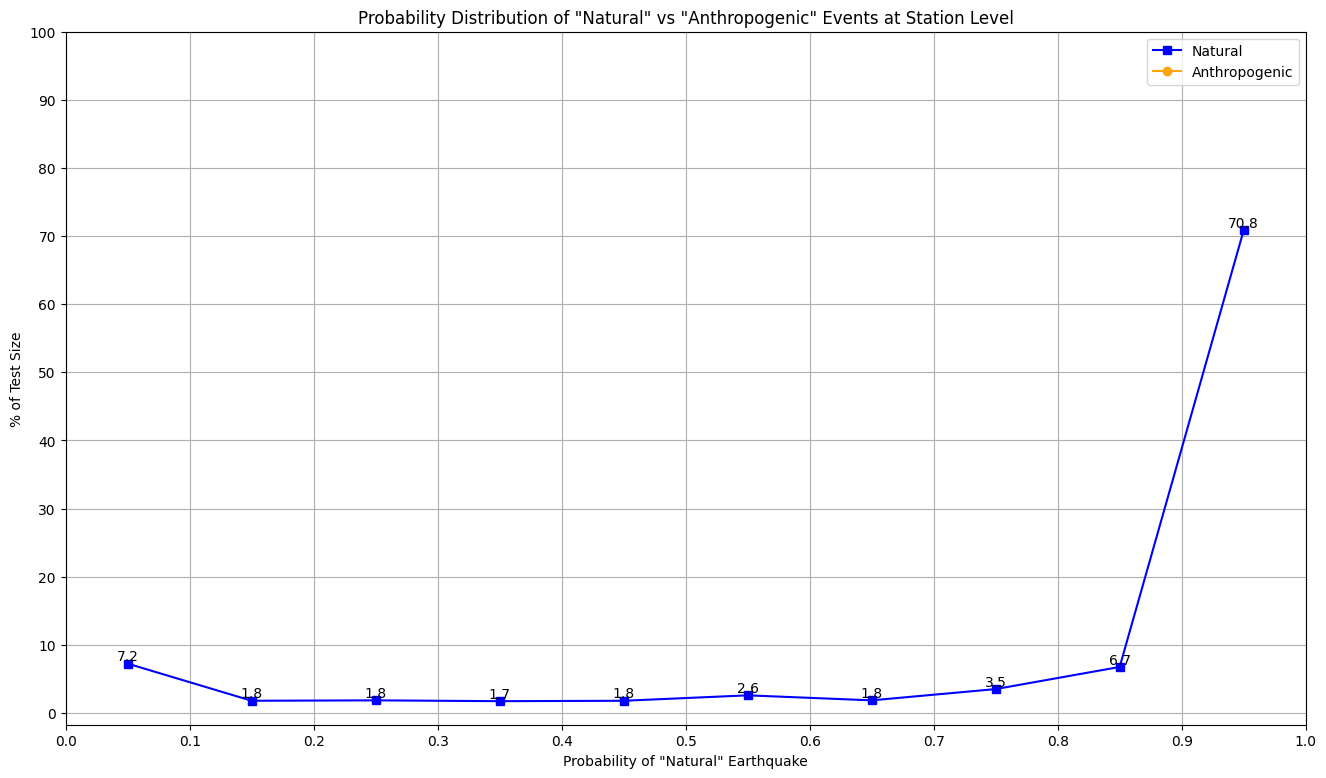

In [8]:
# Suponha que você tenha as seguintes listas de probabilidades para eventos naturais e antropogênicos
prob_anthropogenic = sismo_antrop['prob_nat']
prob_natural = sismo_natural['prob_nat']

# Calcular frequências em porcentagem
freq_natural, bins_natural = np.histogram(prob_natural, bins=np.arange(0, 1.1, 0.1))
freq_anthropogenic, bins_anthropogenic = np.histogram(prob_anthropogenic, bins=np.arange(0, 1.1, 0.1))

# Convert frequency to percentage of the test size
freq_natural = (freq_natural / len(sismo_natural)) *100
freq_anthropogenic = (freq_anthropogenic / len(sismo_antrop))*100

# As posições dos centros dos bins para plotar
bin_centers = (bins_natural[:-1] + bins_natural[1:]) / 2

# Criar o gráfico de linhas
plt.figure(figsize=(16, 9))
plt.plot(bin_centers, freq_natural, marker='s', color='blue', label='Natural')
plt.plot(bin_centers, freq_anthropogenic, marker='o', color='orange', label='Anthropogenic')

# Adicionar anotações com a porcentagem em cima de cada ponto do gráfico
for x, y in zip(bin_centers, freq_natural):
    if y > 0:  # Only annotate if the percentage is greater than 0
        plt.text(x, y, f"{y:.1f}", ha='center', va='bottom')
for x, y in zip(bin_centers, freq_anthropogenic):
    if y > 0:  # Only annotate if the percentage is greater than 0
        plt.text(x, y, f"{y:.1f}", ha='center', va='bottom')

# Configurando os ticks do eixo x e y
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 101, 10))

# Adicionar legendas, títulos e rótulos
plt.legend()
plt.title('Probability Distribution of "Natural" vs "Anthropogenic" Events at Station Level')
plt.xlabel('Probability of "Natural" Earthquake')
plt.ylabel('% of Test Size')

# Mostrar o gráfico
plt.grid(True)
plt.show()

In [9]:
pred_net[pred_net['prob_nat'].isna()]

,event,label_cat,prob_nat,prob_ant,pred,nature
187,20210303T034402,0,NaN,NaN,0,Natural
839,20210303T033554,0,NaN,NaN,0,Natural
1011,20221213T032702,0,NaN,NaN,0,Natural


In [10]:
# Suponha que seu DataFrame seja algo como:
df = pred_net
df.dropna(inplace=True)

Acurácia: 0.856353591160221

Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92      1629
           1       0.00      0.00      0.00         0

    accuracy                           0.86      1629
   macro avg       0.50      0.43      0.46      1629
weighted avg       1.00      0.86      0.92      1629


Matriz de Confusão:
 [[1395  234]
 [   0    0]]


/home/ipt/.config/geo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ipt/.config/geo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ipt/.config/geo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


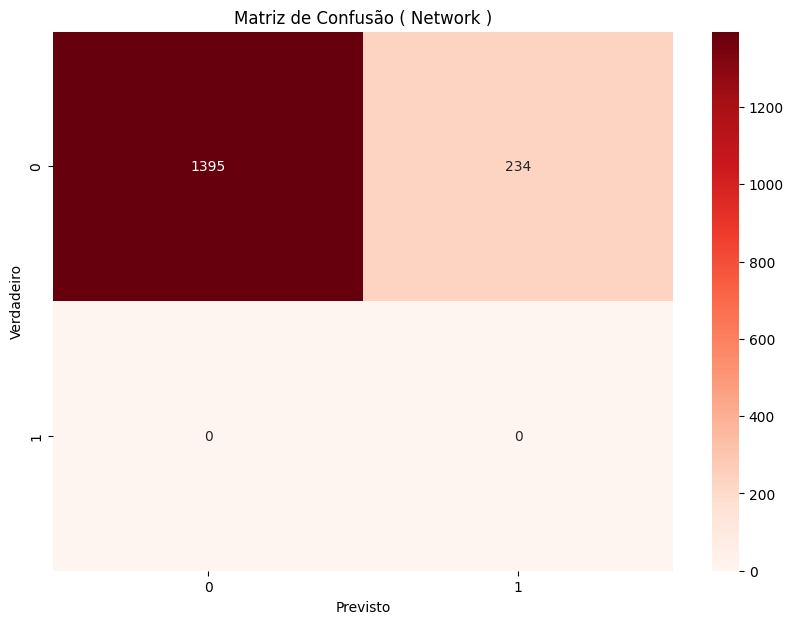

In [11]:
# Extraindo os rótulos verdadeiros e previstos
y_true = df['label_cat']
y_pred = df['pred']

# Calculando a acurácia
accuracy = accuracy_score(y_true, y_pred)
print("Acurácia:", accuracy)

# Gerando o relatório de classificação
report = classification_report(y_true, y_pred)
print("\nRelatório de Classificação:\n", report)

# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nMatriz de Confusão:\n", conf_matrix)

# Criando a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)

# Usando Seaborn para criar um heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Reds')

# Adicionando títulos e rótulos
plt.title('Matriz de Confusão ( Network )')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')

# Ajustando os rótulos (se necessário)
# plt.xticks(ticks=[0.5, 1.5], labels=['Classe 0', 'Classe 1'])
# plt.yticks(ticks=[0.5, 1.5], labels=['Classe 0', 'Classe 1'])

plt.show()

### Extraindo os rótulos verdadeiros e as probabilidades previstas
y_true = df['label_cat']
y_scores = df['prob_ant']

#### Calculando a curva ROC e a AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

#### Plotando a curva ROC
plt.figure(figsize=(12, 9))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC ( Network )')
plt.legend(loc="lower right")
plt.show()

In [78]:
df

,event,label_cat,prob_nat,prob_ant,pred,nature
0,20160323T082644,0,0.998,0.002,0,Natural
1,20210201T102321,0,0.998,0.002,0,Natural
2,20130418T101054,0,0.918,0.082,0,Natural
3,20180725T232908,0,0.979,0.021,0,Natural
4,20210921T032835,0,0.084,0.916,1,Anthropogenic
...,...,...,...,...,...,...
1627,20131101T220809,0,0.992,0.008,0,Natural
1628,20200906T035858,0,0.952,0.048,0,Natural
1629,20151202T014209,0,0.602,0.398,0,Natural
1630,20220505T084227,0,0.998,0.002,0,Natural


### Eventos Classificados como Antropogênicos

In [43]:
antrop_events

,event,label_cat,prob_nat,prob_ant,pred,nature
4,20210921T032835,0,0.084,0.916,1,Anthropogenic
8,20200906T003413,0,0.436,0.564,1,Anthropogenic
15,20170918T082459,0,0.447,0.553,1,Anthropogenic
17,20200510T013526,0,0.039,0.961,1,Anthropogenic
24,20160709T041625,0,0.269,0.731,1,Anthropogenic
...,...,...,...,...,...,...
1612,20120221T063617,0,0.478,0.522,1,Anthropogenic
1614,20230117T100040,0,0.281,0.719,1,Anthropogenic
1619,20230522T225203,0,0.010,0.990,1,Anthropogenic
1622,20190427T034257,0,0.342,0.658,1,Anthropogenic


In [47]:
moho_catalog

,ID,Hora de Origem (UTC),Longitude,Latitude,MLv,Distance,Folder,Cat,Certainty
0,usp2020hkyw,2020-04-15T14:40:20.000000Z,-56.731700,-11.612300,0.175523,0.229345,20200415T144020,earthquake,suspected
1,usp2022gpbs,2022-04-04T15:07:42.000000Z,-40.037400,-3.311600,0.275666,0.452024,20220404T150742,earthquake,suspected
2,usp2014oaxt,2014-07-19T17:30:30.000000Z,-55.363300,-7.050000,0.486036,0.784055,20140719T173030,earthquake,suspected
3,usp2015rxwc,2015-09-12T23:24:35.000000Z,-36.121800,-9.406500,0.645200,33.497183,20150912T232435,earthquake,suspected
4,usp2014kloc,2014-05-29T14:58:30.000000Z,-41.659600,-21.847700,0.731432,2.451453,20140529T145830,earthquake,suspected
...,...,...,...,...,...,...,...,...,...
2328,usp2016yudu,2016-12-18T13:30:11.603076Z,-71.055939,-10.092983,6.223640,318.112159,20161218T133011,earthquake,known
2329,usp2019aium,2019-01-05T19:25:38.577034Z,-71.616203,-8.218705,6.277935,131.640858,20190105T192538,earthquake,known
2330,usp2022lcti,2022-06-08T00:55:45.357024Z,-71.342270,-9.130645,6.477010,215.677267,20220608T005545,earthquake,known
2331,usp2015xbem,2015-11-24T22:45:37.150485Z,-71.126938,-10.666565,7.046137,368.188402,20151124T224537,earthquake,known


In [36]:
merged_df = pd.merge(antrop_events, moho_catalog, left_on='event', right_on='Folder', how='left')

In [37]:
merged_df

,event,label_cat,prob_nat,prob_ant,pred,nature,ID,Hora de Origem (UTC),Longitude,Latitude,MLv,Distance,Folder,Cat,Certainty
0,20210921T032835,0,0.084,0.916,1,Anthropogenic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20200906T003413,0,0.436,0.564,1,Anthropogenic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20170918T082459,0,0.447,0.553,1,Anthropogenic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20200510T013526,0,0.039,0.961,1,Anthropogenic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20160709T041625,0,0.269,0.731,1,Anthropogenic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,20120221T063617,0,0.478,0.522,1,Anthropogenic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230,20230117T100040,0,0.281,0.719,1,Anthropogenic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231,20230522T225203,0,0.010,0.990,1,Anthropogenic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
232,20190427T034257,0,0.342,0.658,1,Anthropogenic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
antrop_events = df[df['pred'] == 1]
print(f' # Eventos classificados como antrópicos: {len(antrop_events)}')

 # Eventos classificados como antrópicos: 234


In [13]:
# Converter a lista de strings para objetos datetime
antrop_events_datetime = [datetime.strptime(date, "%Y%m%dT%H%M%S") for date in antrop_events.event]
# Extrair o ano de cada evento
antrop_years = [date.year for date in antrop_events_datetime]
# Extrair a hora do dia de cada evento
antrop_months = [date.month for date in antrop_events_datetime]
# Extrair a hora do dia de cada evento
antrop_hours = [date.hour for date in antrop_events_datetime]

In [14]:
antrop_events_by_month = defaultdict(list)
antrop_events_by_year = defaultdict(list)

for date in antrop_events_datetime:
    antrop_events_by_month[date.month].append(date.hour)
    antrop_events_by_year[date.year].append(date.hour)

In [15]:
# Lista para armazenar as horas de eventos de cada ano e os respectivos rótulos (anos)
antrop_hours_list = []
antrop_years_labels = []

for year in sorted(antrop_events_by_year.keys()):
    antrop_hours_list.append(antrop_events_by_year[year])
    antrop_years_labels.append(year)

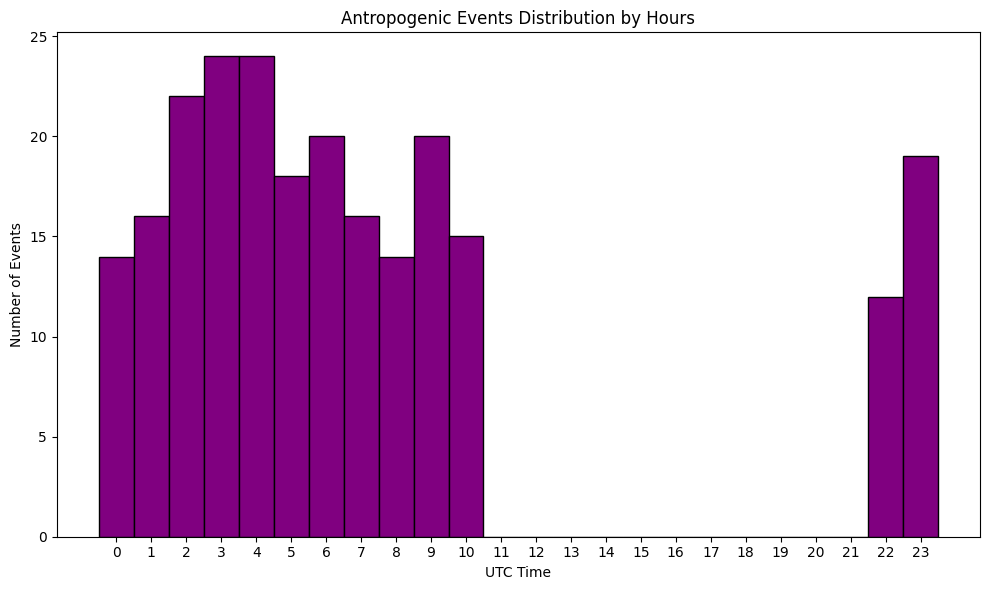

In [16]:
# Plotar o histograma por horas do dia
plt.figure('hours',figsize=(10, 6))
plt.hist(antrop_hours, bins=np.arange(0, 25) - 0.5, color='purple', edgecolor='black')
plt.title('Antropogenic Events Distribution by Hours')
plt.xlabel('UTC Time')
plt.ylabel('Number of Events')
plt.xticks(np.arange(0, 24))
plt.tight_layout()
plt.show()

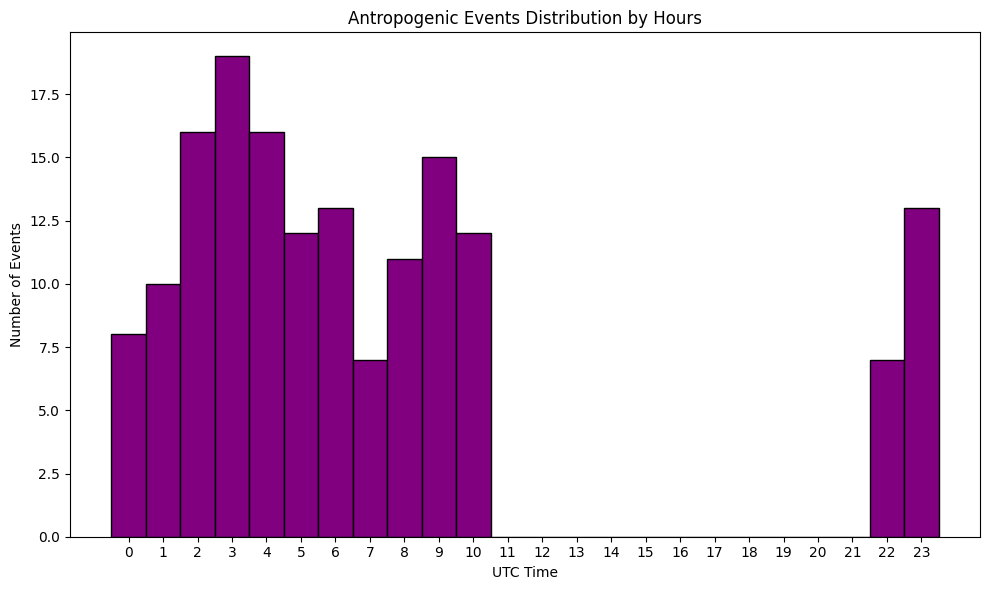

In [214]:
# Plotar o histograma por horas do dia
plt.figure('hours',figsize=(10, 6))
plt.hist(antrop_hours, bins=np.arange(0, 25) - 0.5, color='purple', edgecolor='black')
plt.title('Antropogenic Events Distribution by Hours')
plt.xlabel('UTC Time')
plt.ylabel('Number of Events')
plt.xticks(np.arange(0, 24))
plt.tight_layout()
plt.show()

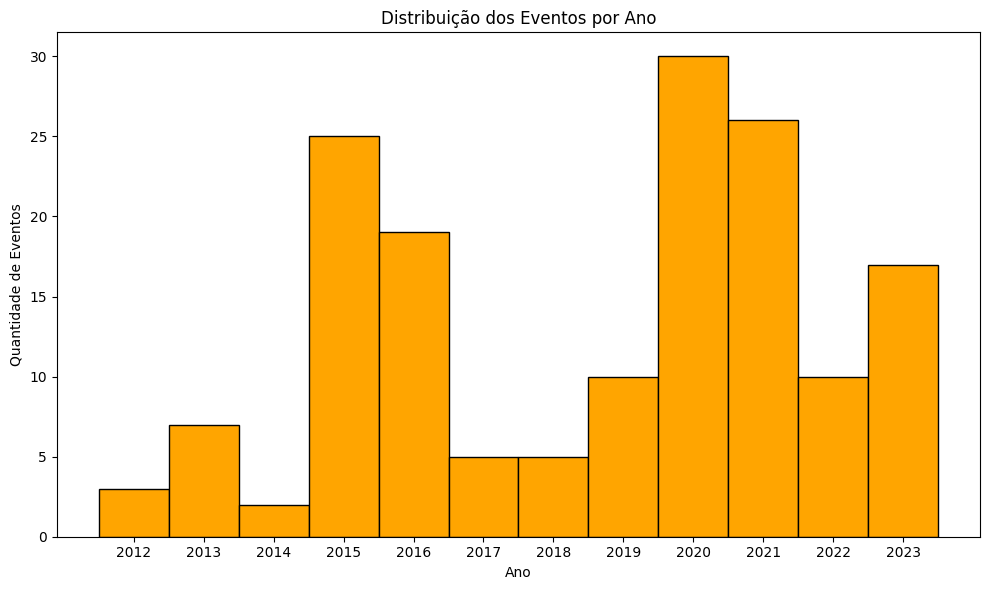

In [207]:
# Plotar o histograma por ano
plt.figure('years',figsize=(10, 6))
plt.hist(antrop_years, bins=np.arange(min(antrop_years), max(antrop_years) + 2) - 0.5, color='orange', edgecolor='black')
plt.title('Distribuição dos Eventos por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Eventos')
plt.xticks(np.arange(min(natural_years), max(antrop_years) + 1))
plt.tight_layout()
plt.show()

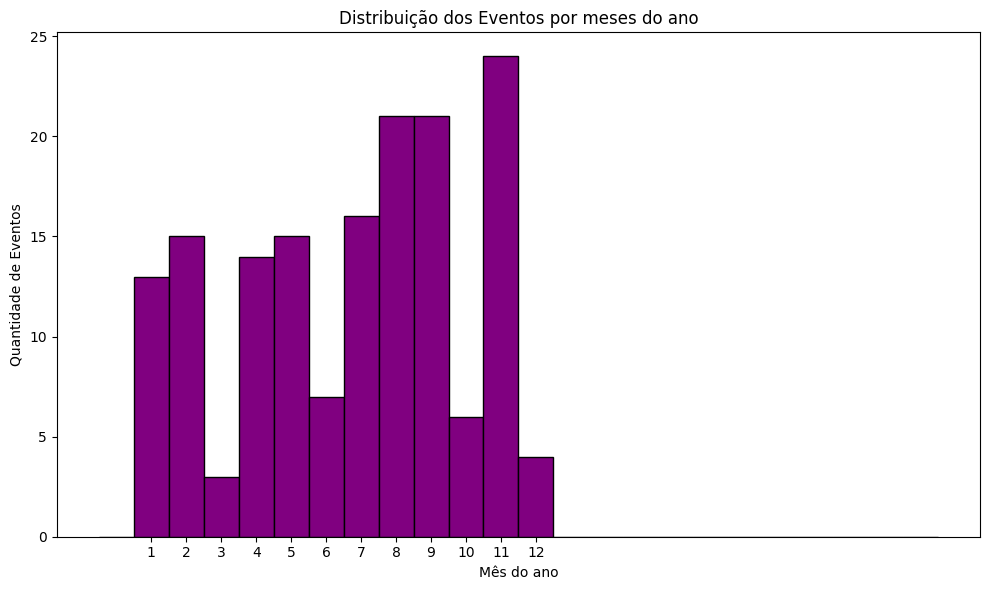

In [208]:
# Plotar o histograma por horas do dia
plt.figure('months',figsize=(10, 6))
plt.hist(antrop_months, bins=np.arange(0, 25) - 0.5, color='purple', edgecolor='black')
plt.title('Distribuição dos Eventos por meses do ano')
plt.xlabel('Mês do ano')
plt.ylabel('Quantidade de Eventos')
plt.xticks(np.arange(1, 13))
plt.tight_layout()
plt.show()

### Eventos Classificados como Naturais

In [103]:
natural_events = df[df['pred'] == 0]
print(f' # Eventos classificados como naturais: {len(natural_events)}')

 # Eventos classificados como naturais: 1395


In [104]:
# Converter a lista de strings para objetos datetime
natural_events_datetime = [datetime.strptime(date, "%Y%m%dT%H%M%S") for date in natural_events.event]
# Extrair o ano de cada evento
natural_years = [date.year for date in natural_events_datetime]
# Extrair a hora do dia de cada evento
natural_months = [date.month for date in natural_events_datetime]
# Extrair a hora do dia de cada evento
natural_hours = [date.hour for date in natural_events_datetime]

natural_events_by_month = defaultdict(list)
natural_events_by_year = defaultdict(list)

for date in natural_events_datetime:
    natural_events_by_month[date.month].append(date.hour)
    natural_events_by_year[date.year].append(date.hour)

# Lista para armazenar as horas de eventos de cada ano e os respectivos rótulos (anos)
natural_hours_list = []
natural_years_labels = []

for year in sorted(natural_events_by_year.keys()):
    natural_hours_list.append(natural_events_by_year[year])
    natural_years_labels.append(year)

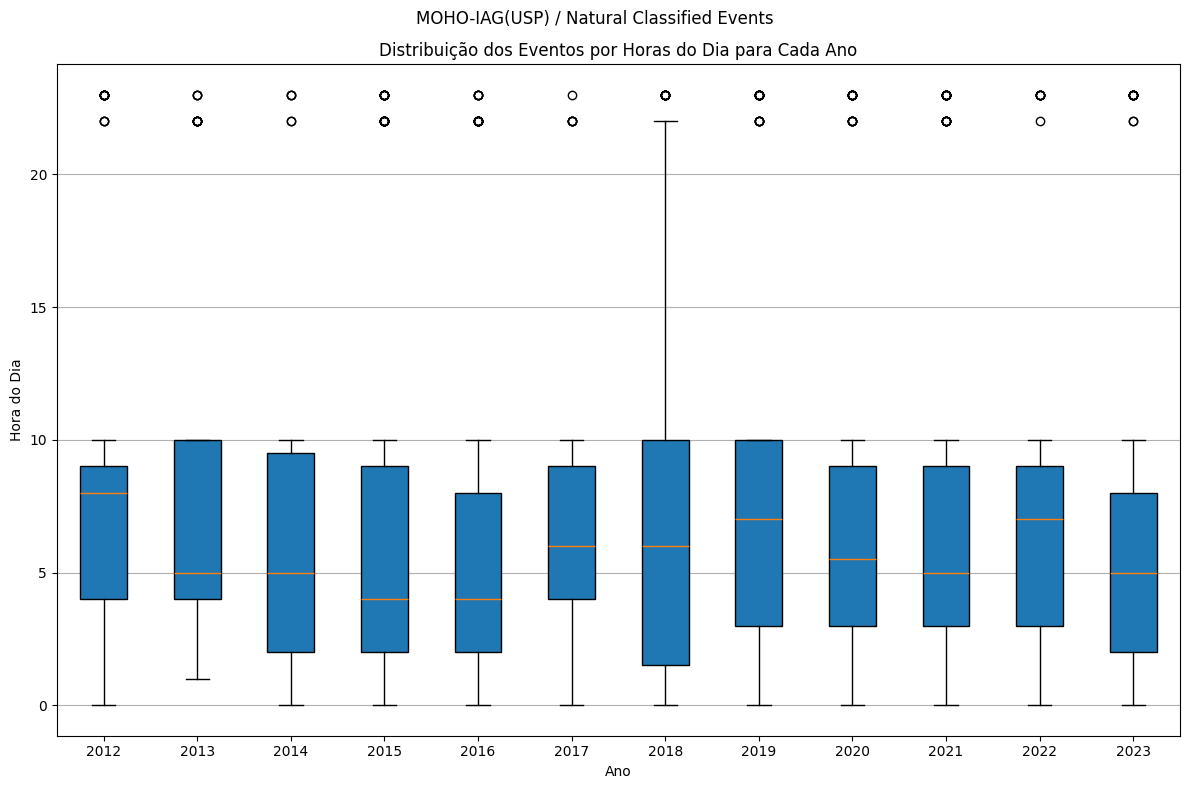

In [105]:
# Plotando os boxplots Hours by Years
plt.figure(figsize=(12, 8))
plt.boxplot(natural_hours_list, patch_artist=True)
plt.suptitle('MOHO-IAG(USP) / Natural Classified Events')
plt.title('Distribuição dos Eventos por Horas do Dia para Cada Ano')
plt.xlabel('Ano')
plt.ylabel('Hora do Dia')
plt.xticks(range(1, len(antrop_years_labels) + 1), antrop_years_labels)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

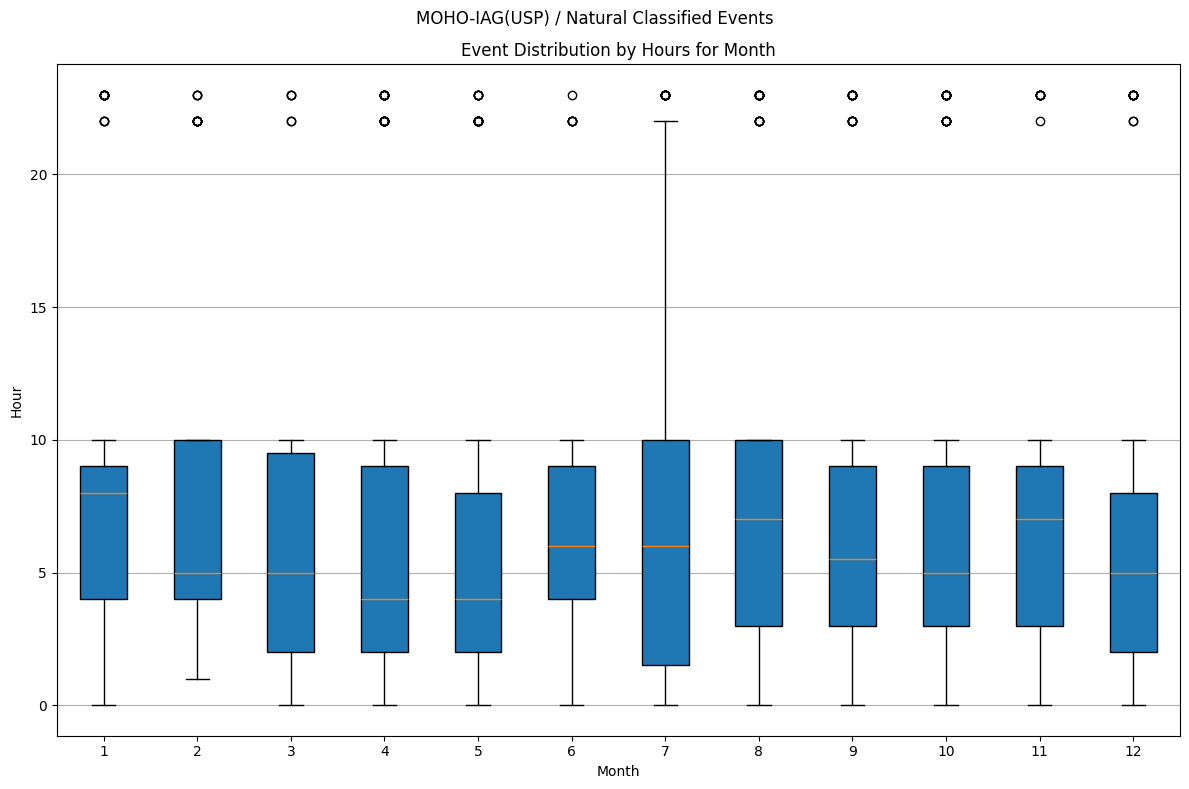

In [106]:
# Plotando os boxplots
plt.figure(figsize=(12, 8))
plt.boxplot(natural_hours_list, patch_artist=True)
plt.suptitle('MOHO-IAG(USP) / Natural Classified Events')
plt.title('Event Distribution by Hours for Month')
plt.xlabel('Month')
plt.ylabel('Hour')
plt.xticks(range(1, len(natural_months_label) + 1), natural_months_label)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

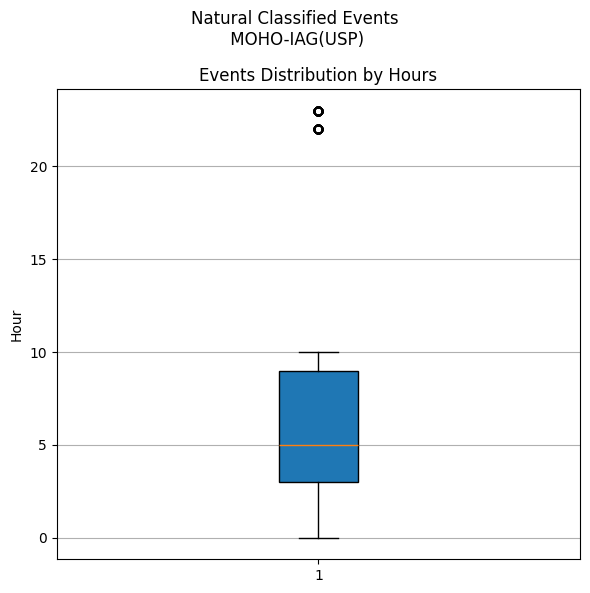

In [107]:
# Plotando os boxplots
plt.figure(figsize=(6, 6))
plt.boxplot(natural_hours, patch_artist=True)
plt.title('Events Distribution by Hours')
plt.suptitle('Natural Classified Events\n MOHO-IAG(USP)')
plt.ylabel('Hour')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

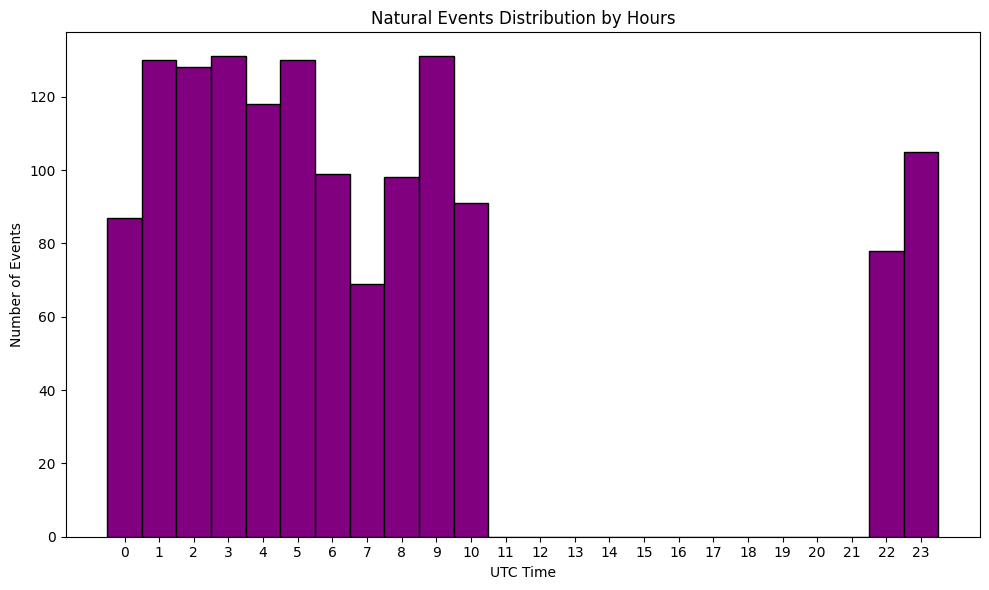

In [108]:
# Plotar o histograma por horas do dia
plt.figure('hours',figsize=(10, 6))
plt.hist(natural_hours, bins=np.arange(0, 25) - 0.5, color='purple', edgecolor='black')
plt.title('Natural Events Distribution by Hours')
plt.xlabel('UTC Time')
plt.ylabel('Number of Events')
plt.xticks(np.arange(0, 24))
plt.tight_layout()
plt.show()

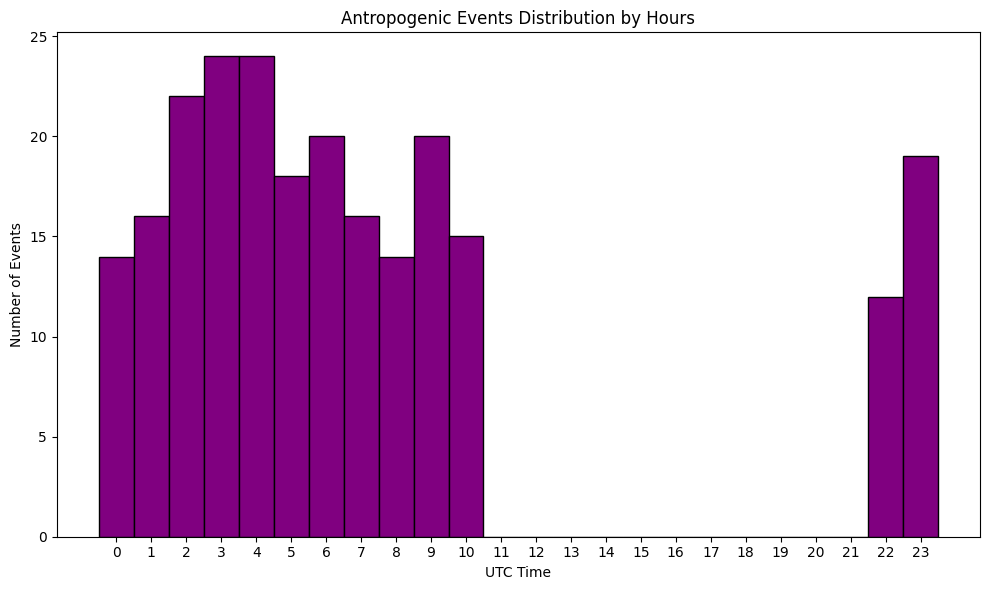

In [109]:
# Plotar o histograma por horas do dia
plt.figure('hours',figsize=(10, 6))
plt.hist(antrop_hours, bins=np.arange(0, 25) - 0.5, color='purple', edgecolor='black')
plt.title('Antropogenic Events Distribution by Hours')
plt.xlabel('UTC Time')
plt.ylabel('Number of Events')
plt.xticks(np.arange(0, 24))
plt.tight_layout()
plt.show()

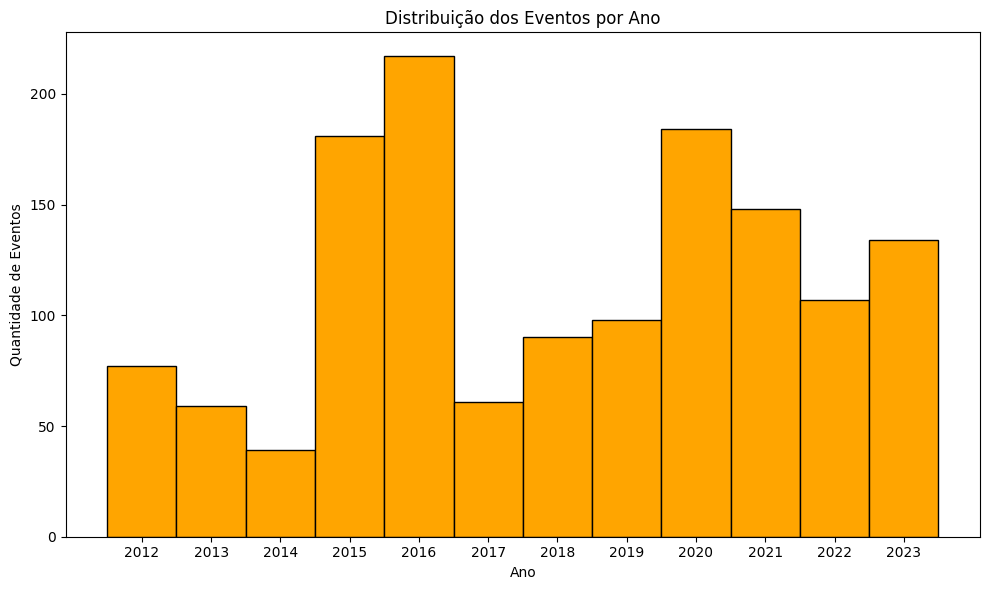

In [112]:
# Plotar o histograma por ano
plt.figure('years',figsize=(10, 6))
plt.hist(natural_years, bins=np.arange(min(natural_years), max(natural_years) + 2) - 0.5, color='orange', edgecolor='black')
plt.title('Distribuição dos Eventos por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Eventos')
plt.xticks(np.arange(min(natural_years), max(natural_years) + 1))
plt.tight_layout()
plt.show()

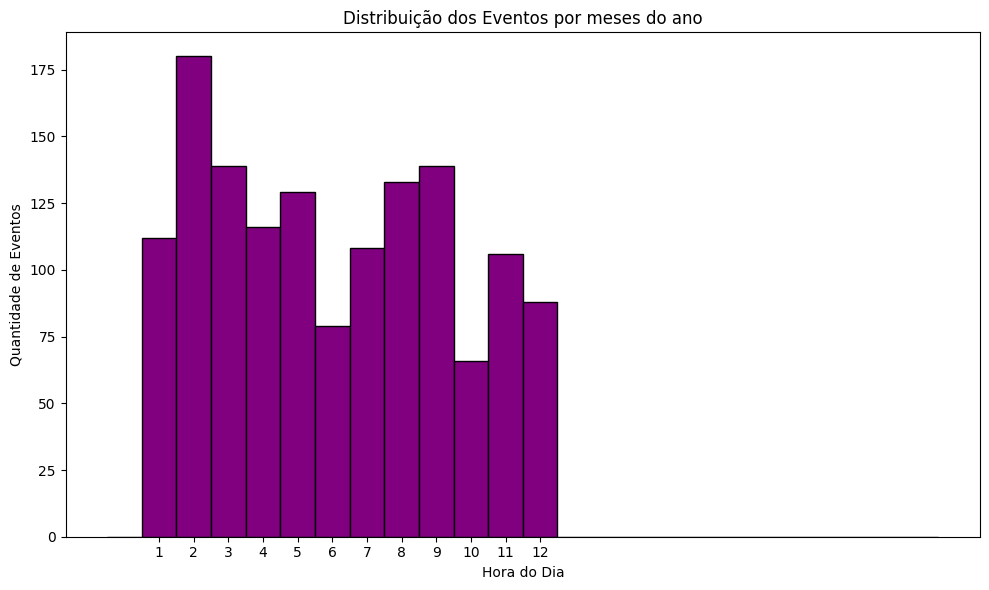

In [113]:
# Plotar o histograma por horas do dia
plt.figure('months',figsize=(10, 6))
plt.hist(natural_months, bins=np.arange(0, 25) - 0.5, color='purple', edgecolor='black')
plt.title('Distribuição dos Eventos por meses do ano')
plt.xlabel('Hora do Dia')
plt.ylabel('Quantidade de Eventos')
plt.xticks(np.arange(1, 13))
plt.tight_layout()
plt.show()

## Predições em Estação

In [48]:
pred_sta = pd.read_csv("../files/output/validation_station_level.csv")
pred_sta.head()

,file_name,station,label_cat,prob_nat,prob_ant,pred,nature
0,NB_NBAN_20160323T082644,NBAN,0,0.998,0.002,0,Natural
1,BR_BOAV_20210201T102321,BOAV,0,0.998,0.002,0,Natural
2,BL_MCI6_20130418T101054,MCI6,0,0.918,0.082,0,Natural
3,ON_DUB01_20180725T232908,DUB01,0,0.979,0.021,0,Natural
4,NB_NBPA_20210921T032835,NBPA,0,0.084,0.916,1,Anthropogenic


In [49]:
pred_sta.describe().T

,count,mean,std,min,25%,50%,75%,max
label_cat,1715.0,0.00000,0.000000,0.000,0.00000,0.00,0.00000,0.000
prob_nat,1712.0,0.82668,0.300795,0.001,0.84475,0.98,0.99700,1.000
prob_ant,1712.0,0.17332,0.300795,0.000,0.00300,0.02,0.15525,0.999
pred,1715.0,0.15102,0.358173,0.000,0.00000,0.00,0.00000,1.000


In [50]:
sismo_natural = pred_sta[pred_sta['label_cat'] == 0]
print(f'sismos naturais - > {len(sismo_natural)}')

sismo_antrop = pred_sta[pred_sta['label_cat'] == 1]
print(f'sismos antrópicos - > {len(sismo_antrop)}')

sismos naturais - > 1715
sismos antrópicos - > 0


In [51]:
sismo_falso_natural = sismo_antrop[sismo_antrop['pred'] == 0 ]
print(f'sismos naturais falsos - > {len(sismo_falso_natural)}')

sismo_falso_antro = sismo_natural[sismo_natural['pred'] == 1 ]
print(f'sismos antropogênicos falsos - > {len(sismo_falso_antro)}')

sismos naturais falsos - > 0
sismos antropogênicos falsos - > 259


In [52]:
sismo_verdadeiro_natural = sismo_natural[sismo_natural['pred'] == 0 ]
print(f'sismos naturais verdadeiros - > {len(sismo_verdadeiro_natural)}')

sismo_verdadeiro_antro = sismo_antrop[sismo_antrop['pred'] == 1 ]
print(f'sismos antropogênicos verdadeiros - > {len(sismo_verdadeiro_antro)}')

sismos naturais verdadeiros - > 1456
sismos antropogênicos verdadeiros - > 0


/tmp/ipykernel_1135724/1350128421.py:11: RuntimeWarning: divide by zero encountered in divide
  freq_anthropogenic = (freq_anthropogenic / len(prob_anthropogenic)) * 100
/tmp/ipykernel_1135724/1350128421.py:11: RuntimeWarning: invalid value encountered in divide
  freq_anthropogenic = (freq_anthropogenic / len(prob_anthropogenic)) * 100


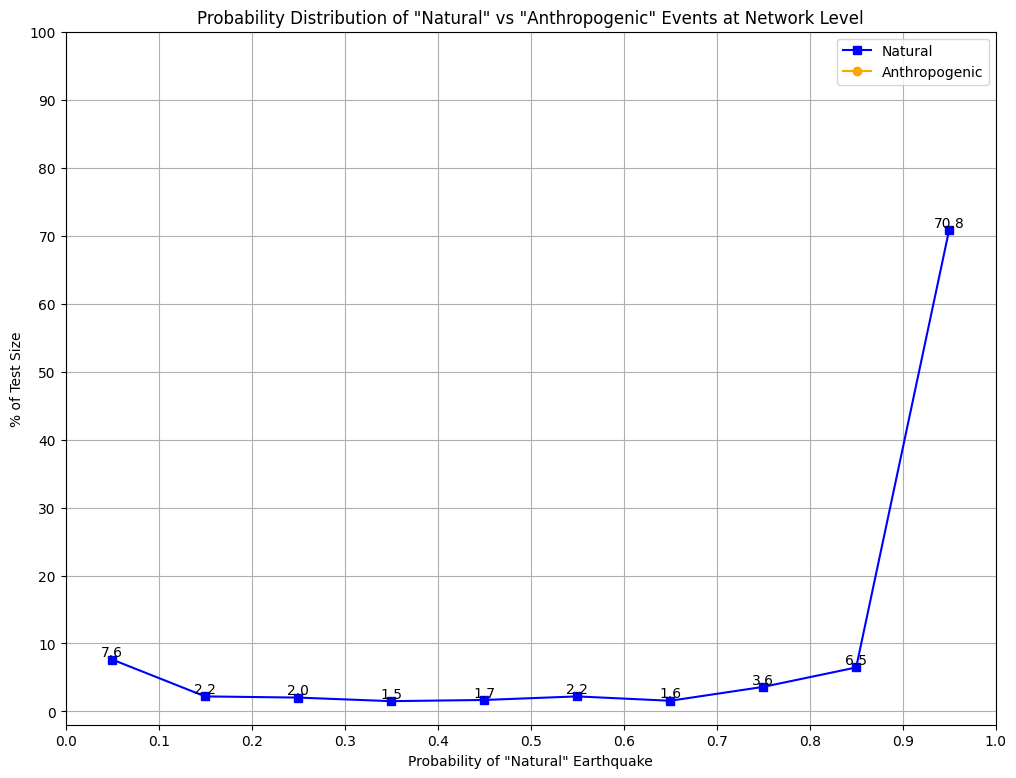

In [53]:
# Suponha que você tenha as seguintes listas de probabilidades para eventos naturais e antropogênicos
prob_anthropogenic = sismo_antrop['prob_nat']
prob_natural = sismo_natural['prob_nat']

# Calcular frequências em porcentagem
freq_natural, bins_natural = np.histogram(prob_natural, bins=np.arange(0, 1.1, 0.1))
freq_anthropogenic, bins_anthropogenic = np.histogram(prob_anthropogenic, bins=np.arange(0, 1.1, 0.1))

# Convert frequency to percentage of the test size
freq_natural = (freq_natural / len(prob_natural)) * 100
freq_anthropogenic = (freq_anthropogenic / len(prob_anthropogenic)) * 100

# As posições dos centros dos bins para plotar
bin_centers = (bins_natural[:-1] + bins_natural[1:]) / 2

# Criar o gráfico de linhas
plt.figure(figsize=(12, 9))
plt.plot(bin_centers, freq_natural, marker='s', color='blue', label='Natural')
plt.plot(bin_centers, freq_anthropogenic, marker='o', color='orange', label='Anthropogenic')

# Adicionar anotações com a porcentagem em cima de cada ponto do gráfico
for x, y in zip(bin_centers, freq_natural):
    if y > 0:  # Only annotate if the percentage is greater than 0
        plt.text(x, y, f"{y:.1f}", ha='center', va='bottom')
for x, y in zip(bin_centers, freq_anthropogenic):
    if y > 0:  # Only annotate if the percentage is greater than 0
        plt.text(x, y, f"{y:.1f}", ha='center', va='bottom')

# Configurando os ticks do eixo x e y
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 101, 10))

# Adicionar legendas, títulos e rótulos
plt.legend()
plt.title('Probability Distribution of "Natural" vs "Anthropogenic" Events at Network Level')
plt.xlabel('Probability of "Natural" Earthquake')
plt.ylabel('% of Test Size')

# Mostrar o gráfico
plt.grid(True)
plt.show()

/home/ipt/.config/geo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ipt/.config/geo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ipt/.config/geo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acurácia: 0.8489795918367347

Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92      1715
           1       0.00      0.00      0.00         0

    accuracy                           0.85      1715
   macro avg       0.50      0.42      0.46      1715
weighted avg       1.00      0.85      0.92      1715


Matriz de Confusão:
 [[1456  259]
 [   0    0]]


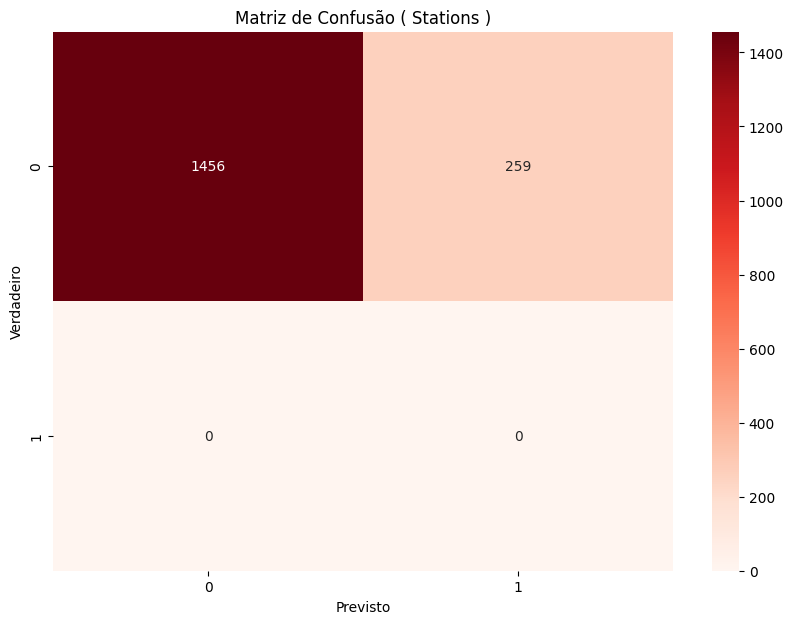

In [54]:
# Suponha que seu DataFrame seja algo como:
df = pred_sta

# Extraindo os rótulos verdadeiros e previstos
y_true = df['label_cat']
y_pred = df['pred']

# Calculando a acurácia
accuracy = accuracy_score(y_true, y_pred)
print("Acurácia:", accuracy)

# Gerando o relatório de classificação
report = classification_report(y_true, y_pred)
print("\nRelatório de Classificação:\n", report)

# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nMatriz de Confusão:\n", conf_matrix)

# Criando a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)

# Usando Seaborn para criar um heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Reds')

# Adicionando títulos e rótulos
plt.title('Matriz de Confusão ( Stations )')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')

# Ajustando os rótulos (se necessário)
# plt.xticks(ticks=[0.5, 1.5], labels=['Classe 0', 'Classe 1'])
# plt.yticks(ticks=[0.5, 1.5], labels=['Classe 0', 'Classe 1'])

plt.show()

In [55]:
df.dropna(inplace=True)
df

,file_name,station,label_cat,prob_nat,prob_ant,pred,nature
0,NB_NBAN_20160323T082644,NBAN,0,0.998,0.002,0,Natural
1,BR_BOAV_20210201T102321,BOAV,0,0.998,0.002,0,Natural
2,BL_MCI6_20130418T101054,MCI6,0,0.918,0.082,0,Natural
3,ON_DUB01_20180725T232908,DUB01,0,0.979,0.021,0,Natural
4,NB_NBPA_20210921T032835,NBPA,0,0.084,0.916,1,Anthropogenic
...,...,...,...,...,...,...,...
1710,NB_NBTA_20200906T035858,NBTA,0,0.952,0.048,0,Natural
1711,BL_PTGB_20151202T014209,PTGB,0,0.226,0.774,1,Anthropogenic
1712,ON_TIJ01_20151202T014209,TIJ01,0,0.979,0.021,0,Natural
1713,NB_NBMO_20220505T084227,NBMO,0,0.998,0.002,0,Natural


In [56]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
label_cat,1712.0,0.000000,0.000000,0.000,0.00000,0.00,0.00000,0.000
prob_nat,1712.0,0.826680,0.300795,0.001,0.84475,0.98,0.99700,1.000
prob_ant,1712.0,0.173320,0.300795,0.000,0.00300,0.02,0.15525,0.999
pred,1712.0,0.151285,0.358431,0.000,0.00000,0.00,0.00000,1.000


In [57]:
# Extraindo os rótulos verdadeiros e as probabilidades previstas
y_true = df['label_cat']
y_scores = df['prob_ant']

# Calculando a curva ROC e a AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Plotando a curva ROC
plt.figure(figsize=(12, 9))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC  ( Stations )')
plt.legend(loc="lower right")
plt.show()

/home/ipt/.config/geo/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.